# 4 Monte Carlo simulation

## 4.1.1

In [1]:
import numpy as np

In [3]:
f = np.random.normal
f()

0.23602111709063425

In [10]:
def phi(x):
    return np.cos(x)**2

In [17]:
sample = []
n = 1000000
for i in range(n):
    x = f()
    sample.append(phi(x))

In [18]:
np.mean(sample), np.var(sample)

(0.567635927058451, 0.12037431285502707)

In [25]:
from scipy.stats import entropy

def calc_entropy(labels, base=None):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

In [30]:
calc_entropy(sample, 2)

19.931568569324213

## 4.1.2

In [31]:
A = np.random.normal

In [32]:
n_exp = 10

In [33]:
def score_func(param):
    return np.random.normal(param)

In [56]:
A_list = [A() for i in range(n_exp)]

S_list = [score_func(a) for a in A_list]

from scipy import stats
stats.pearsonr(A_list, S_list)

(0.962487651902296, 8.279227684086728e-06)

# 4.2 Importance Sampling

## 4.2.1

In [ ]:
from scipy.stats import norm, uniform

In [112]:
X = norm(0, 1)
q = uniform(-5, 10)  # see the doc

In [99]:
sample = []
n = 100000
for i in range(n):
    x = q.rvs()
    importance = X.pdf(x) / q.pdf(x)
    sample.append(importance*x**2)
np.mean(sample), np.var(sample)

(0.9998105970667793, 1.1155581807660564)

In [88]:
sample = []
n = 100000
for i in range(n):
    x = X.rvs()
    sample.append(x**2)
np.mean(sample), np.var(sample)

(1.0040202859077625, 2.0247428257227953)

## 4.2.2

In [134]:
def f(x):
    return (1 + np.cos(np.pi*x)) / 2

In [130]:
g = uniform(-1, 2)

In [135]:
sample = []
n = 10000
for i in range(n):
    x = g.rvs()
    importance = f(x) / g.pdf(x)
    sample.append(importance*x**2)
np.mean(sample), np.var(sample)

(0.1304328288301676, 0.008167369297755534)

# Kullback-Leibler divergence

In [145]:
N1 = norm(2, 4)
N2 = norm(0, 1)

sample = []
n = 10000
for i in range(n):
    x = N1.rvs()
    ratio = N1.pdf(x) / N2.pdf(x)
    value = importance*np.log1p(ratio)
#     if np.isnan(value):
#         print('x', x)
#         print('importance', importance)
#         print('value', value)
        
    sample.append(value)
np.mean(sample), np.var(sample)

(1.079530680213215, 2.6684462068099486)

# Exploitation versus Exploration

## UCB versus ε-greedy for k-bandit problem

In [ ]:
import matplotlib.pyplot as plt

In [289]:
class Bandit:
    def __init__(self, mean=None, var=None):
        if not mean:
            mean = np.random.uniform(0, 5)
        if not var:
            var = np.random.uniform(0, 2)
        self.arm = norm(mean, var)
    def pull(self,):
        return self.arm.rvs()

In [290]:
class MultiArmedBandit():
    def __init__(self, k, mean_list=None, var_list=None):
        if not mean_list:
            mean_list = [None for i in range(k)]
        if not var_list:
            var_list = [None for i in range(k)]
            
        self.arms_num = k
        
        self.arms = [Bandit(mean, var) for mean, var in zip(mean_list, var_list)]
    def pull(self, k):
        assert 0 <= k <= self.arms_num, f"There are only {self.arms_num} (from 0 to {self.arms_num-1}) defined"
        return self.arms[k].pull()

In [381]:
class eGreedyAgent:
    def __init__(self, epsilon, k, initial_value):
        self.epsilon = epsilon
        self.k = k
        self.q = [initial_value for i in range(k)]
        self.n_selected = [0 for i in range(k)]
        self.regrets = []
        self.lai_robbins = 0
        self.correct_decisions = 0
        self.cum_reward = []
        self.rewards = []
        
    def action(self, ):
        p = np.random.uniform(0, 1)
        if p > self.epsilon:
            max_q = max(self.q)
            candidate_ids = [i for i, q in enumerate(self.q) if q == max_q]
            selected_arm = np.random.choice(candidate_ids)
            self.correct_decisions += 1
        else:
            selected_arm = np.random.choice(range(self.k))
        return selected_arm
    
    def get_prob(self, k):
        max_q = max(self.q)
        if self.q[k] == max_q:
            return 1 - self.epsilon
        else:
            return self.epsilon

    def update_estimates(self, selected_arm, reward):
        if len(self.regrets):
            self.regrets.append(self.regrets[-1] + max(self.q) - self.q[selected_arm])
            self.cum_reward.append(self.cum_reward[-1] + reward)
        else:
            self.regrets.append(max(self.q) - self.q[selected_arm])
            self.cum_reward.append(reward)
            
        self.rewards.append(reward)
            
#         delta = max(self.q) - self.q[selected_arm]
#         if delta != 0.:
#             f_a = self.get_prob(selected_arm)
#             f_a_start = 1-self.epsilon  # self.get_prob()
#         self.lai_robbins += 0
        
        self.n_selected[selected_arm] += 1
        self.q[selected_arm] = self.q[selected_arm] + (
            reward - self.q[selected_arm]) / self.n_selected[selected_arm]

In [382]:
class UCBAgent:
    def __init__(self, c, k, initial_value):
        self.k = k
        self.c = c
        self.q = [initial_value for i in range(k)]
        self.n_selected = [0 for i in range(k)]
        self.regrets = []
        self.lai_robbins = 0
        self.t = 0
        self.correct_decisions = 0
        self.cum_reward = []
        self.rewards = []

    def action(self, ):
        ucb_values = [
            self.q[k] +
            self.c * np.sqrt(np.log1p(self.t) / (self.n_selected[k] + 0.0001))
            for k in range(self.k)
        ]
#         print('UCB values', ucb_values)
        max_ucb = max(ucb_values)
        candidate_ids = [i for i, q in enumerate(ucb_values) if q == max_ucb]
        selected_arm = np.random.choice(candidate_ids)
        
        max_q = max(self.q)
        best_actions = [i for i, q in enumerate(self.q) if q == max_q]
        if selected_arm in best_actions:
            self.correct_decisions += 1
        
        self.t += 1
        return selected_arm

#     def get_prob(self, k):
#         max_q = max(self.q)
#         if self.q[k] == max_q:
#             return 1 - self.epsilon
#         else:
#             return self.epsilon

    def update_estimates(self, selected_arm, reward):
        if len(self.regrets):
            self.regrets.append(self.regrets[-1] + max(self.q) -
                                self.q[selected_arm])
            self.cum_reward.append(self.cum_reward[-1] + reward)
        else:
            self.regrets.append(max(self.q) - self.q[selected_arm])
            self.cum_reward.append(reward)
            
        self.rewards.append(reward)


#         delta = max(self.q) - self.q[selected_arm]
#         if delta != 0.:
#             f_a = self.get_prob(selected_arm)
#             f_a_start = 1-self.epsilon  # self.get_prob()
#         self.lai_robbins += 0

        self.n_selected[selected_arm] += 1
        self.q[selected_arm] = self.q[selected_arm] + (
            reward - self.q[selected_arm]) / self.n_selected[selected_arm]

In [383]:
k = 5
mab = MultiArmedBandit(k)

In [384]:
plt.rcParams["figure.figsize"] = (15, 9)

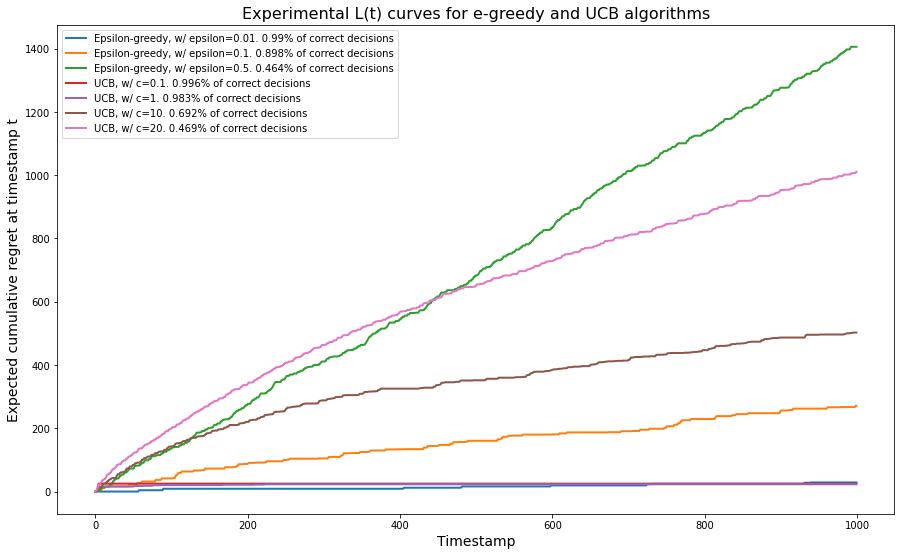

In [395]:
for eps in [0.01, 0.1, 0.5]:
    agent = eGreedyAgent(eps, k, 0)
    for i in range(1000):
        selected_arm = agent.action()
    #     print('selected_arm', selected_arm)
        reward = mab.pull(selected_arm)
    #     print('reward', reward)
        agent.update_estimates(selected_arm, reward)
    #     print('updated q', agent.q)
    #     print('updated regrets', agent.regrets)

    #     print('\n')
    plt.plot(range(0, len(agent.regrets)), agent.regrets, 
             label=f"Epsilon-greedy, w/ epsilon={agent.epsilon}. {agent.correct_decisions/1000}% of correct decisions",
             linewidth=2)

for c in [0.1, 1, 10, 20]:
    agent = UCBAgent(c, k, 0)
    for i in range(1000):
        selected_arm = agent.action()
    #     print('selected_arm', selected_arm)
        reward = mab.pull(selected_arm)
    #     print('reward', reward)
        agent.update_estimates(selected_arm, reward)
    #     print('updated q', agent.q)
    #     print('updated regrets', agent.regrets)

    #     print('\n')
    plt.plot(range(0, len(agent.regrets)), agent.regrets, 
             label=f"UCB, w/ c={agent.c}. {agent.correct_decisions/1000}% of correct decisions",
             linewidth=2)

plt.legend()
plt.title('Experimental L(t) curves for e-greedy and UCB algorithms', fontsize=16);
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Expected cumulative regret at timestamp t", fontsize=14)
plt.show()

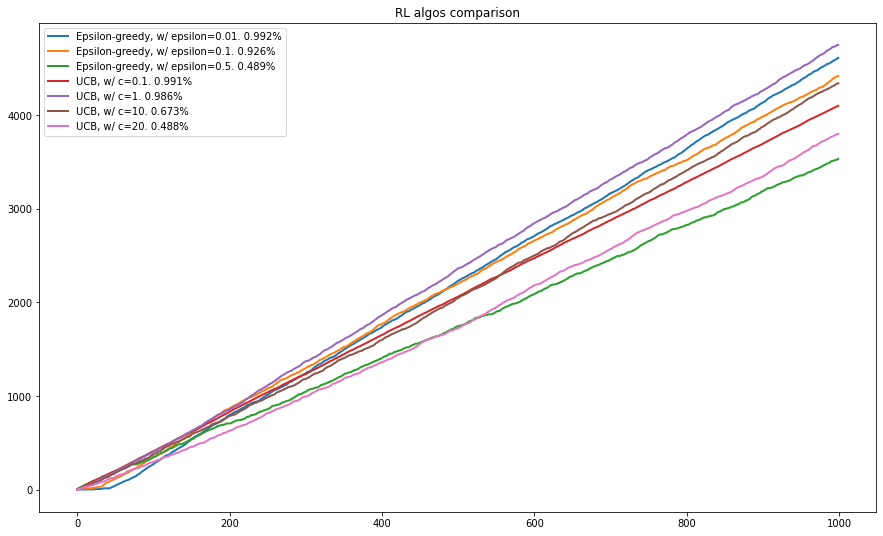

In [392]:
for eps in [0.01, 0.1, 0.5]:
    agent = eGreedyAgent(eps, k, 0)
    for i in range(1000):
        selected_arm = agent.action()
    #     print('selected_arm', selected_arm)
        reward = mab.pull(selected_arm)
    #     print('reward', reward)
        agent.update_estimates(selected_arm, reward)
    #     print('updated q', agent.q)
    #     print('updated cum_reward', agent.cum_reward)

    #     print('\n')
    plt.plot(range(0, len(agent.cum_reward)), agent.cum_reward, 
             label=f"Epsilon-greedy, w/ epsilon={agent.epsilon}. {agent.correct_decisions/1000}%",
             linewidth=2)

for c in [0.1, 1, 10, 20]:
    agent = UCBAgent(c, k, 0)
    for i in range(1000):
        selected_arm = agent.action()
    #     print('selected_arm', selected_arm)
        reward = mab.pull(selected_arm)
    #     print('reward', reward)
        agent.update_estimates(selected_arm, reward)
    #     print('updated q', agent.q)
    #     print('updated cum_reward', agent.cum_reward)

    #     print('\n')
    plt.plot(range(0, len(agent.cum_reward)), agent.cum_reward, 
             label=f"UCB, w/ c={agent.c}. {agent.correct_decisions/1000}%",
             linewidth=2)

plt.legend()
plt.title('RL algos comparison');
plt.show()

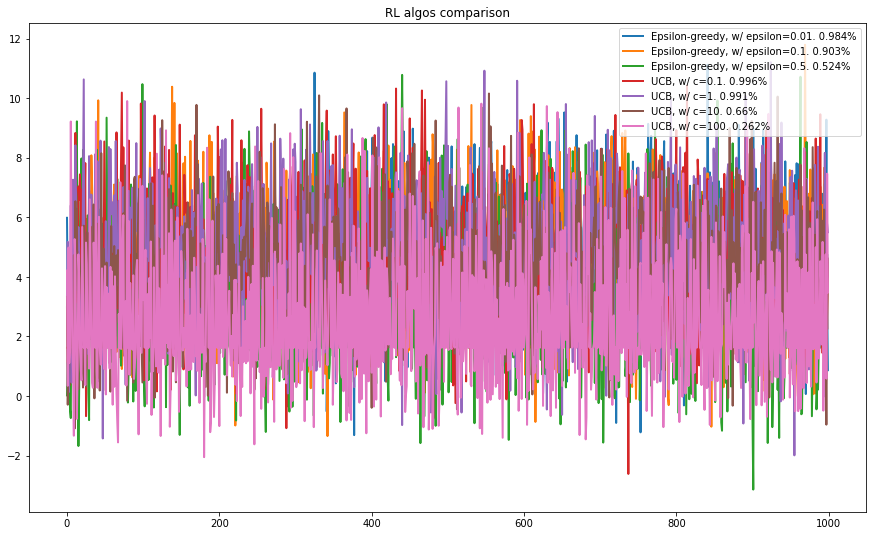

In [387]:
for eps in [0.01, 0.1, 0.5]:
    agent = eGreedyAgent(eps, k, 0)
    for i in range(1000):
        selected_arm = agent.action()
    #     print('selected_arm', selected_arm)
        reward = mab.pull(selected_arm)
    #     print('reward', reward)
        agent.update_estimates(selected_arm, reward)
    #     print('updated q', agent.q)
    #     print('updated rewards', agent.rewards)

    #     print('\n')
    plt.plot(range(0, len(agent.rewards)), agent.rewards, 
             label=f"Epsilon-greedy, w/ epsilon={agent.epsilon}. {agent.correct_decisions/1000}%",
             linewidth=2)

for c in [0.1, 1, 10, 100]:
    agent = UCBAgent(c, k, 0)
    for i in range(1000):
        selected_arm = agent.action()
    #     print('selected_arm', selected_arm)
        reward = mab.pull(selected_arm)
    #     print('reward', reward)
        agent.update_estimates(selected_arm, reward)
    #     print('updated q', agent.q)
    #     print('updated rewards', agent.rewards)

    #     print('\n')
    plt.plot(range(0, len(agent.rewards)), agent.rewards, 
             label=f"UCB, w/ c={agent.c}. {agent.correct_decisions/1000}%",
             linewidth=2)

plt.legend()
plt.title('RL algos comparison');
plt.show()

# HW 6

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Monte Carlo Sampling (20%)

Use MC sampling to get insight in the following important sequential decision problem. This
problem surfaces in different guises in lots of real world applications, but we will phrase it in terms of house rental.   
Renting a house in Amsterdam As you are probably well aware there is a shortage of affordable housing in Amsterdam. As an upward moving young professional you’re interested in renting your first home. You’ve contacted a real estate agent who has arranged n appointments for site visits of houses that fit within your budget. These visits are scheduled at specific dates and times, so you will visit the houses in pre-fixed order (which you can think of as a random permutation of the sequence 1,2,3,...,n). Assume that at the end of each visit you are able to assign a score 0 ≤ x ≤ 1 that captures your preference: E.g. x = 1: OMG!! My dream house!! ; x = 0: no way i’m living in this dump! ; x = 0.2: hmmmm, . . . only if the rent is really low; ; x = 0.8: this house has a lot of potential, . . . etc.  
https://en.wikipedia.org/wiki/Secretary_problem

Assumptions We’ll make the following assumptions:
1. You really need a place to live, so you do have to pick one of the n options.
2. If you could visit all the houses before making a decision, life would be easy: after each site visit you assign a score and when you’ve seen all n of them, you pick the house with the highest score (for simplicity’s sake, we assume there are no ties, so there is a unique ranking).
3. However, life isn’t that simple. At the end of each visit you have to decide on the spot whether or not you will rent the place. If you decide not to, then someone else will immediately snap it up. Put differently, changing your mind at at later stage is impossible: your decision at the end of the visit is final.
4. Your goal, of course, is to maximise the probability that you will pick the best house in the list.
5. Assume that n is sufficiently large, in other words, we are really interested in the asymptotic behaviour as n →∞.

Questions
1. What strategy would you use? Use MC to explore possible approaches and/or motivate your
answer.
2. Can you suggest interesting variations on this question (that I could maybe use in next year’s assignment :-)? No need to provide a solution, formulating the question suffices.  


PS This is an exercise on MC simulation, so no need to cast this problem into the framework
of sequential game theory.

$U C B 1=V_{i}+2 \sqrt{\frac{\ln N}{n_{i}}}$

In [21]:
class DecisionMaker:
    def __init__(self, expected_size):
        self.expected_size = expected_size
        self.past_scores = []
        self._max_past = None

    @property
    def max_past(self):
        if self._max_past is None:
            if not self.past_scores:
                return None
            else:
                self._max_past = max(self.past_scores)
                return self._max_past
        else:
            return self._max_past

    def make_decision(self, score):
        pass
    
class ThresholdDecisioner(DecisionMaker):
    def __init__(self, expected_size, threshold):
        super().__init__(expected_size)
        self.threshold = threshold
        
    def make_decision(self, score):
        if score > self.threshold or len(self.past_scores) == (self.expected_size - 1):
            stop = True
        else:
            stop = False
        self.past_scores.append(score)
        return stop

In [4]:
from tqdm.notebook import tqdm
from copy import deepcopy
from random import shuffle

def mc_simulation(decisioner, n_houses, simulations):
    decisioner_virgin = deepcopy(decisioner)

    house_scores = np.random.uniform(0, 1, size=n_houses)
    max_score = max(house_scores)
    stop_step_list = []
    percent_of_max_list = []
    
    for _ in tqdm(range(simulations), total=simulations):
        shuffle(house_scores)
        decisioner = deepcopy(decisioner_virgin)
        
        stop_step = None
        percent_of_max = None
        stop = False

        for i, score in enumerate(house_scores, 1):
            stop = decisioner.make_decision(score)
            if stop:
                stop_step = i
                percent_of_max = score / max_score
                break
        stop_step_list.append(stop_step)
        percent_of_max_list.append(percent_of_max)
        
    return stop_step_list, percent_of_max_list, house_scores, decisioner

  0%|          | 0/100 [00:00<?, ?it/s]

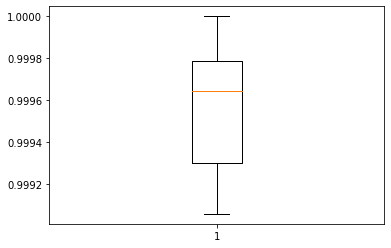

In [12]:
n_houses = 100000
simulations = 100

threshold_decisioner = ThresholdDecisioner(n_houses, 0.999)

stop_step_list, percent_of_max_list, house_scores, decisioner = mc_simulation(
    threshold_decisioner, n_houses=n_houses, simulations=simulations)

plt.boxplot(percent_of_max_list);

In [22]:
class OddsAlgorithm(DecisionMaker):
    def __init__(self, expected_size):
        super().__init__(expected_size)
        self.reject_threshold = int(expected_size / np.e)
        
    def make_decision(self, score):
        if len(self.past_scores) < self.reject_threshold:
            stop = False
        else:
            if score > self.max_past or len(self.past_scores) == (self.expected_size - 1):
                stop = True
            else:
                stop = False
        self.past_scores.append(score)
        return stop

  0%|          | 0/1000 [00:00<?, ?it/s]

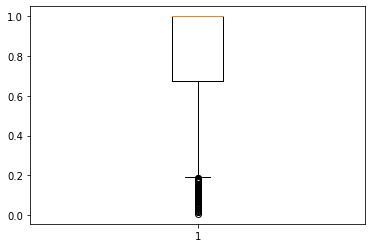

In [29]:
n_houses = 10000
simulations = 1000

odds_decisioner = OddsAlgorithm(n_houses)

stop_step_list, percent_of_max_list, house_scores, decisioner = mc_simulation(
    odds_decisioner, n_houses=n_houses, simulations=simulations)

plt.boxplot(percent_of_max_list);

In [30]:
len([x for x in percent_of_max_list if x == 1.]) / simulations

0.38

In [31]:
1/np.e

0.36787944117144233

## Monte Carlo Tree Search (MCTS) (30%)

**Construct a binary tree** of depth d = 12 (or more – if you’re feeling lucky). Since the tree is binary, there are two branches (aka. edges, directions, decisions, etc) emanating from each node, each branch (call them L(eft) and R(ight)) pointing to a unique child node (except, of course, for the leaf nodes – see Fig 1). We can therefore assign to each node a unique “address” (A) that captures the route down the tree to reach that node (e.g. A = LLRL – for an example, again see Fig 1).  
**Assign values to leaf-nodes** - to each of the 2d leaf-nodes a value as follows:
* First, pick a random leaf-node as your target node and let’s denote its address as At.
* For every leaf-node i compute the edit-distance between its address Ai and At, i.e.
d(Ai,At).
* Recall that the edit-distance counts the number of positions at which two strings differ, e.g.:
    * d(LRLR,LRRR) = 1, 
    * d(LRRL,LLLL) = 2, 
    * d(RRLL,RLRR) = 3
* Finally, define the value xi of leaf-node i to be a decreasing function of the distance di =
d(Ai,At) to the target node: e.g. 

$x_{i}=B e^{-d_{i} / \tau}$

where B and τ are chosen such that most nodes have a non-negligible value.

Questions
* Implement the MCTS algorithm and apply it to the above tree to search for the optimal
(i.e. highest) value.
* Collect statistics on the performance and discuss the role of the hyperparameter c in the UCB-score.  
Assume that the number MCTS-iterations starting in a specific root node is limited (e.g. to 10 or
50). Make a similar assumption for the number of roll-outs starting in a particular (”snowcap”)
leaf node (e.g. 1 or 5).

In [24]:
from collections import defaultdict

In [87]:
# # https://stackoverflow.com/questions/2460177/edit-distance-in-python
# def levenshteinDistance(s1, s2):
#     if len(s1) > len(s2):
#         s1, s2 = s2, s1

#     distances = range(len(s1) + 1)
#     for i2, c2 in enumerate(s2):
#         distances_ = [i2+1]
#         for i1, c1 in enumerate(s1):
#             if c1 == c2:
#                 distances_.append(distances[i1])
#             else:
#                 distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
#         distances = distances_
#     return distances[-1]

# levenshteinDistance('LRR', 'LLL')

In [89]:
def edit_distance(str1, str2):
    dist = 0
    for l, r in zip(str1, str2):
        if l != r:
            dist += 1
    return dist

edit_distance('LRLR', 'LRRR'), edit_distance('LRRL', 'LLLL'), edit_distance('RRLL', 'RLRR')

(1, 2, 3)

In [853]:
from itertools import chain 

class Node:
    def __init__(self, val=0):
        self.left = None
        self.right = None
        self.reward = val
        self.path = None
        self.level = None
        
    def get_children_list(self):
        children = [self.left, self.right]
        if all(ch is None for ch in children):
            return []
        else:
            return children
        
    def get_random_child(self):
        return random.choice(self.get_children_list())
    
    @property
    def is_terminal(self):
        if self.get_children_list():
            return False
        else:
            return True


class BinaryTree:
    def __init__(self, depth=2):
        self.root = None
        self.level2nodes_dict = defaultdict(list)
        self.levels = None

        for level in range(depth + 1):
            if level == 0:
                self.setRoot(None)
            else:
                prev_level_nodes = self.get_level_values(level-1)
                for node in prev_level_nodes:
#                     if level == depth:
#                         left_node = Node(random.uniform(0, 100))
#                         right_node = Node(random.uniform(0, 100))
#                     else:
#                         left_node = Node(0)
#                         right_node = Node(0)
                    left_node = Node(val=None)
                    right_node = Node(val=None)

                    node.left = left_node
                    left_node.path = node.path + 'L'
                    left_node.level = level
                    self.level2nodes_dict[level].append(left_node)

                    node.right = right_node
                    right_node.path = node.path + 'R'
                    right_node.level = level
                    self.level2nodes_dict[level].append(right_node)
                    
            self.levels = level

    def getRoot(self):
        return self.root
    
    def setRoot(self, val):
        root_node = Node(val)
        self.root = root_node
        self.root.path = ''
        self.level2nodes_dict[0] = [root_node]
        self.level = 0

    def get_level_values(self, n):
        return self.level2nodes_dict[n]
    
    def init_leaf_nodes(self, func, **kwargs):
        leaf_nodes = self.level2nodes_dict[self.levels]
        
        self.target_idx = random.randint(0, len(leaf_nodes))
        self.target_node = leaf_nodes[self.target_idx]
        self.target_path = self.target_node.path
        
        for idx, node in enumerate(leaf_nodes):
            dist = edit_distance(self.target_path, node.path)
            node.reward = func(dist, **kwargs)
            
    def get_all_nodes(self):
        all_nodes = []
        for level in range(self.levels+1):
            all_nodes.append(self.get_level_values(level))
        return list(chain.from_iterable(all_nodes))   
        
        
#     def is_terminal(self):
#         if self.left is None and self.right is None:
#             return True
#         return False

#     def printTree(self):
#         if self.root is not None:
#             self._printTree(self.root)

#     def _printTree(self, node):
#         if node is not None:
#             self._printTree(node.l)
#             print(str(node.v) + ' ')
#             self._printTree(node.r)

In [854]:
import random
import numpy as np

In [863]:
depth = 12

bin_tree = BinaryTree(depth)
bin_tree.levels

12

In [864]:
def func(dist, B, tau):
    return np.exp(-dist/tau)*B

In [865]:
bin_tree.init_leaf_nodes(func, B=1, tau=0.5)

In [866]:
# [(node.path, nodereward) for node in bin_tree.level2nodes_dict[6]]

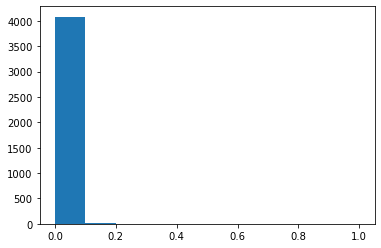

In [867]:

plt.hist([node.reward for node in bin_tree.level2nodes_dict[depth]]);

In [949]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, simulations_limit=100, num_rollouts=5, exploration_weight=1.0, verbose=1):
        self.Q = defaultdict(float)  # total reward of each node
        self.N = defaultdict(float)  # total visit count for each node
        # children of each node: key is explored node, value is set of children
        self.children = dict()
        
        self.num_rollouts = num_rollouts
        
        self.simulations_limit = simulations_limit
        self.simulations_counter = 0
        self.budget_exhausted_flag = False
        
        self.exploration_weight = exploration_weight
        self.verbose = verbose

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        #         # All children of node should already be expanded:
        #         # a node is fully expanded if and only if all children are explored
        #         is_all_children_expanded = all(n in self.children for n in self.children[node])
        #         if not is_all_children_expanded:
        #             raise ValueError("Can only select from fully expanded node")

        log_N_parent = np.log1p(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / (self.N[n] + 0.00001) + self.exploration_weight * np.sqrt(
                log_N_parent / (self.N[n] + 0.00001))

        children = node.get_children_list()
        return max(children, key=uct)

    def select(self, node: Node):
        "Find the most promising KNOWN node. Stop if has at least one unexplored"
        path = []
        while True:
            path.append(node)
            if self.verbose > 2:
                print("selection. current path:", [node.path for node in path])
            
            if node.is_terminal:  # last level = no children
                return path
            
            children = node.get_children_list()
            if self.verbose > 2:
                print(f'for node "{node.path}" there children are{[(ch.path, ch.reward, self.N[ch], self.Q[ch]) for ch in children]}')

            explored = [child for child in children if self.N[child]]  # if was visited at least once
#             if len(explored) == 0:  # both children are unexplored
#                 return path
#             if len(explored) == 1:
#                 next_node = explored[0]
#                 node = next_node
#                 continue
            if len(explored) < 2:
                return path

            node = self._uct_select(node)  # both are explored - descend a layer deeper
            
    def expand(self, node):
        "Select an unexplored node for which we will simulate rollouts"
        if node.is_terminal:
            return None
        children = node.get_children_list()
        if self.verbose > 2:
            print(f'expand. for node "{node.path}" there children are{[(ch.path, ch.reward) for ch in children]}')

        return [child for child in children if not self.N[child]][0]
    
    def simulate(self, node):
        "Run a random simulation from node as starting point"
        while True:
            if node.is_terminal:
                return node.reward
            node = node.get_random_child()
            if self.verbose > 3:
                print('simulate. randomly selected', node.path)
                
    def backup(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            if self.verbose > 3:
                print(f"updating '{node.path}'", f'\nwas N={self.N[node]}, prev Q={self.Q[node]}')
            self.N[node] += 1
            self.Q[node] += reward
            if self.verbose > 3:
                print(f'new N={self.N[node]}, prev Q={self.Q[node]}')
                
    def get_next_root(self, node: Node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal:
            raise RuntimeError(f"choose called on terminal node {node.path}")

        children = node.get_children_list()
        explored = [child for child in children if self.N[child]]  # if was visited at least once
        if len(explored) == 0:  # both children are unexplored
            return node.get_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(explored, key=score)
    
    def iterate(self, node):
        "Run on iteration of select -> expand -> simulation(rollout) -> backup"
        path = self.select(node)
        if self.verbose > 1:
            print("path from selection:", [node.path for node in path])
        leaf = path[-1]
        expanded_node = self.expand(leaf)
        if expanded_node is not None:
            path.append(expanded_node)
        else:
            expanded_node = leaf
            
        if self.verbose > 1:
            print("expanded_node:", (expanded_node.path, expanded_node.reward))
        reward = 0
        for i in range(self.num_rollouts):
            reward += self.simulate(expanded_node)
            self.simulations_counter += 1
            if self.simulations_counter >= self.simulations_limit:
                self.budget_exhausted_flag = True
                if self.verbose > 0:
                    print("The budget is exhausted")
                break
        self.backup(path, reward)
        
    def get_best_node(self, bin_tree: BinaryTree):
        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward
        
        all_nodes = bin_tree.get_all_nodes()

        return max(all_nodes, key=score)
        
    def run(self, bin_tree):
        root = bin_tree.getRoot()
        counter = 0 
        best_iter_rewards = []
        while True:
            while not self.budget_exhausted_flag:
                self.iterate(root)
                counter += 1
                
                best_node = self.get_best_node(bin_tree)
                best_avg_reward = self.Q[best_node] / (self.N[best_node]*self.num_rollouts + 0.00001)
                best_iter_rewards.append(best_avg_reward)
                if self.verbose > 0 and counter % 10 == 0:
                    print(f"{counter}-th iteration: {best_node.path, best_node.reward, best_avg_reward}")
            
            new_root = self.get_next_root(root)
            if self.verbose > 0:
                print(f"change root node '{root.path}'->'{new_root.path}'")
            root = new_root
            self.simulations_counter = 0
            self.budget_exhausted_flag = False
            
            # we repeat until root is terminal
            if root.is_terminal:
                print("Found optimal (max) leaf node: {}, value: {}".format(root.path, root.reward))
                return root, best_iter_rewards

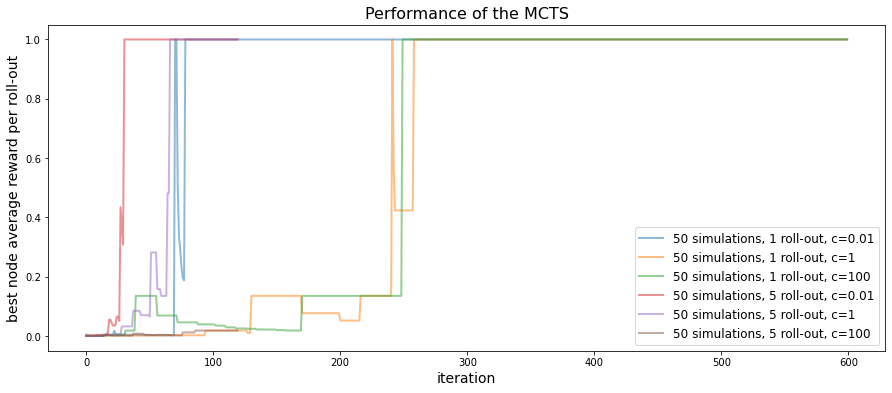

In [967]:
results = dict()

for sims in [50]:#[10, 50]:
    for rolls in [1, 5]:
        for c in [0.01, 1, 100]:

            mcts = MCTS(simulations_limit=sims, 
                        num_rollouts=rolls, 
                        exploration_weight=c,
                        verbose=0)
            best_node, best_iter_rewards = mcts.run(bin_tree)
            
            results[f"{sims} simulations, {rolls} roll-out, c={c}"] = best_iter_rewards
            
df = pd.DataFrame.from_dict(results, orient='index').T
df.index.name = 'iter'
df.reset_index('iter', inplace=True)

df.plot(x="iter", figsize=(15, 6), alpha=0.5, lw=2)
plt.legend(fontsize=12)
plt.ylabel('best node average reward per roll-out', fontsize=14)
plt.xlabel('iteration', fontsize=14);
plt.title('Performance of the MCTS', fontsize=16);

Found optimal (max) leaf node: RLLLLLLLLRLL, value: 0.1353352832366127
Found optimal (max) leaf node: LRLLLLLRLRLL, value: 0.01831563888873418
Found optimal (max) leaf node: RLLLLLLLLRLL, value: 0.1353352832366127
Found optimal (max) leaf node: LLLLLLLLLRLL, value: 1.0
Found optimal (max) leaf node: LLLLLLLLLRLL, value: 1.0
Found optimal (max) leaf node: LLLLLLLLLRLL, value: 1.0


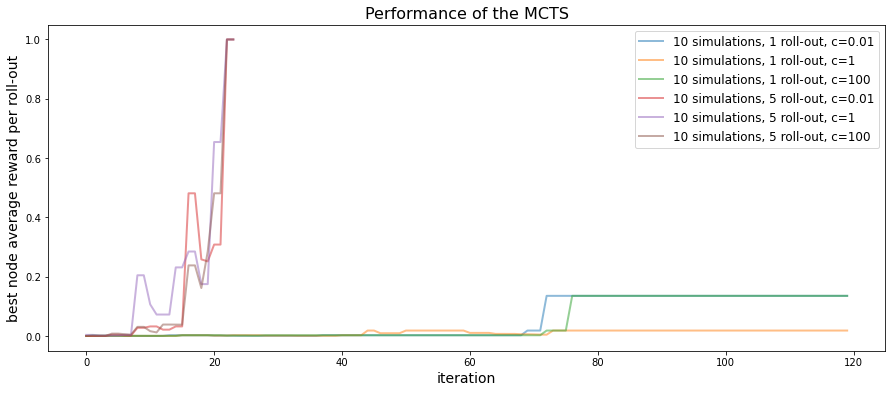

In [968]:
results = dict()

for sims in [10]:
    for rolls in [1, 5]:
        for c in [0.01, 1, 100]:

            mcts = MCTS(simulations_limit=sims, 
                        num_rollouts=rolls, 
                        exploration_weight=c,
                        verbose=0)
            best_node, best_iter_rewards = mcts.run(bin_tree)
            
            results[f"{sims} simulations, {rolls} roll-out, c={c}"] = best_iter_rewards
            
df = pd.DataFrame.from_dict(results, orient='index').T
df.index.name = 'iter'
df.reset_index('iter', inplace=True)

df.plot(x="iter", figsize=(15, 6), alpha=0.5, lw=2)
plt.legend(fontsize=12)
plt.ylabel('best node average reward per roll-out', fontsize=14)
plt.xlabel('iteration', fontsize=14);
plt.title('Performance of the MCTS', fontsize=16);

In [969]:
best_node = mcts.get_best_node(bin_tree)
best_node.path

'LLLLLLLLLRLL'

In [970]:
bin_tree.target_path

'LLLLLLLLLRLL'

In [971]:
def safe_round(v):
    if v is None: return None
    else: return round(v, 2)

for level in range(bin_tree.levels + 1):
    level_nodes = bin_tree.get_level_values(level)
    values = [str((safe_round(node.reward), int(mcts.N[node]), round(mcts.Q[node]/(mcts.N[node] + 0.00001), 1))) for node in level_nodes]
    print(' '.join(values).center(100))

                                           (None, 2, 0.0)                                           
                                   (None, 3, 0.0) (None, 1, 0.0)                                    
                    (None, 3, 0.0) (None, 1, 0.0) (None, 0, 0.0) (None, 0, 0.0)                     
(None, 3, 0.0) (None, 1, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0)
(None, 3, 0.1) (None, 1, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0)
(None, 3, 0.1) (None, 1, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 0, 0.0) (None, 

In [972]:
mcts.Q[bin_tree.target_node]

5.0

## Reinforcement Learning: SARSA and Q-Learning for Gridworld(50%)

Consider the 9 ×9 gridworld example. The blue gridcells represent walls that cannot be traversed. The green cell represent a treasure and transition to this cell yields a reward of +50 whereupon the episode is terminated (i.e. absorbing state). The red cell represents the snakepit: this state is also absorbing and entering it yields a negative reward of −50. All other cells represent regular states that are accessible to the agent. In each cell, the agent
can take four actions: move north, east, south or west. These actions result in a deterministic
transition to the corresponding neighbouring cell. An action that makes the agent bump into a
wall or the grid-borders, leaves its state unchanged. All non-terminal transitions (including running into walls or grid borders) incur a negative reward (”cost”) of −1. For the questions below, we assume that the agent is not aware of all the above information and needs to discover it by interacting with the environment (i.e. model-free setting). Perform, and comment on, the following experiments:

### Env

In [2]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:" + fmt + "}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:" + str(col_maxes[i]) + fmt + "}").format(y), end="  ")
        print("")

In [3]:
class GridWorldEnv:
    def __init__(self,
                 size,
                 obstacles,
                 terminal_cells,
                 step_penalty,
                 verbose=0):
        self.grid = np.zeros(size)
        self.obstacles = obstacles
        self.terminal_cells = terminal_cells
        self.step_penalty = step_penalty
        self.verbose = verbose

    def env_init(self, start_state):
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state, boolean
            indicating if it's terminal.
        """

        # Note, we can setup the following variables later, in env_start() as it is equivalent.
        # Code is left here to adhere to the note above, but these variables are initialized once more
        # in env_start() [See the env_start() function below.]

        reward = None
        state = None
        termination = None
        self.reward_state_term = (reward, state, termination)

        self.grid_h, self.grid_w = self.grid.shape

        # Now, we can define a frame of reference. Let positive x be towards the direction down and
        # positive y be towards the direction right (following the row-major NumPy convention.)
        # Then, keeping with the usual convention that arrays are 0-indexed, max x is then grid_h - 1
        # and max y is then grid_w - 1. So, we have:
        # Starting location of agent is the bottom-left corner, (max x, min y).
        self.start_loc = start_state

        for i, (x, y) in enumerate(self.obstacles):
            if x < 0 or x > self.grid_h - 1:
                logging.warning(
                    f"{i}-th obstacle has X coordinate out of Grid Bounds. The obstance will be ignored."
                )
                continue
            if y < 0 or y > self.grid_w - 1:
                logging.warning(
                    f"{i}-th obstacle has Y coordinate out of Grid Bounds. The obstance will be ignored."
                )
                continue

    def env_start(self):
        """The first method called when the episode starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """
        reward = 0
        # agent_loc will hold the current location of the agent
        self.agent_loc = self.start_loc
        # state is the one dimensional state representation of the agent location.
        if self.is_terminal(self.start_loc[0], self.start_loc[1]):
            termination = True
        else:
            termination = False
        self.reward_state_term = (reward, self.agent_loc, termination)

        return self.reward_state_term

    def is_in_bounds(self, x, y):
        if x < 0 or x > self.grid_h - 1:
            return False
        if y < 0 or y > self.grid_w - 1:
            return False
        return True

    def is_stuck_with_obstacle(self, x, y):
        return any(
            ((x_obs == x) and (y_obs == y)) for x_obs, y_obs in self.obstacles)

    def is_terminal(self, x, y):
        return (x, y) in self.terminal_cells

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state,
                and boolean indicating if it's terminal.
        """

        x, y = self.agent_loc
        # by default, assume -1 reward per step and that we did not terminate
        reward = -self.step_penalty
        terminal = False

        # UP
        if action == 0:
            x -= 1

        # LEFT
        elif action == 1:
            y -= 1

        # DOWN
        elif action == 2:
            x += 1

        # RIGHT
        elif action == 3:
            y += 1

        # Uh-oh
        else:
            raise Exception(
                str(action) +
                " not in recognized actions [0: Up, 1: Left, 2: Down, 3: Right]!"
            )

        # If the action takes the agent out-of-bounds
        # then the agent stays in the same state
        # and gains a penalty
        if not self.is_in_bounds(x, y) or self.is_stuck_with_obstacle(x, y):
            if self.verbose > 1:
                print('Faced bound or obstacle')
            x, y = self.agent_loc

        if self.is_terminal(x, y):
            reward = self.terminal_cells[(x, y)]
            terminal = True

        # assign the new location to the environment object
        self.agent_loc = (x, y)

        self.reward_state_term = (reward, self.agent_loc, terminal)
        return self.reward_state_term

In [4]:
obstacles = [(1,2), (1,3), (1,4), (1,5), (1,6),
             (7,1), (7,2), (7,3), (7,4),
             (2,6), (3,6), (4,6), (5,6)]
terminal_cells = {(6,5): -50, 
                  (8,8): 50}

env = GridWorldEnv(size=(9, 9), 
                   obstacles=obstacles, 
                   terminal_cells=terminal_cells, 
                   step_penalty=1,
                   verbose=0)

In [1125]:
for obs in env.obstacles:
    env.grid[obs] = 1
for k, v in env.terminal_cells.items():
    env.grid[k] = v
    
matprint(env.grid)

0  0  0  0  0    0  0  0   0  
0  0  1  1  1    1  1  0   0  
0  0  0  0  0    0  1  0   0  
0  0  0  0  0    0  1  0   0  
0  0  0  0  0    0  1  0   0  
0  0  0  0  0    0  1  0   0  
0  0  0  0  0  -50  0  0   0  
0  1  1  1  1    0  0  0   0  
0  0  0  0  0    0  0  0  50  


### Monte-Carlo

Use Monte Carlo policy evaluation to compute the state value function vπ(s) for the equiprobable policy π (i.e. all 4 actions have probability 1/4). Visualize the result (e.g. by using some sort of heat map where the color of each cell corresponds to the state value).

In [8]:
def equprobable_policy():
    return random.randint(0, 3)

class SweepEveryVisitMonteCarlo:
    def __init__(self, env, ):
        self.env = env
#         self.v_table = np.zeros(self.env.grid.shape)
        self.N = np.zeros(self.env.grid.shape)
        self.returns_sum = np.zeros(self.env.grid.shape)
    
    def evaluate_v(self, iters):
        for _ in range(iters):
            for h in range(self.env.grid.shape[0]):
                for w in range(self.env.grid.shape[1]):
                    if (h, w) in env.obstacles:
                        continue
                    env.env_init(start_state=(h, w))
                    _, start_state, terminal = env.env_start()
                    
                    episode = []
                    while not terminal:  # generate an episode
                        reward, state, terminal = self.env.env_step(equprobable_policy())
                        episode.append((reward, state, terminal))
                    
                    G = 0
                    for reward, state, _ in episode[::-1]:
                        G += reward
                        self.N[state[0], state[1]] += 1
                        self.returns_sum[state[0], state[1]] += G
        self.v_table = self.returns_sum / self.N
        return self.v_table

In [9]:
%%time

mc = SweepEveryVisitMonteCarlo(env)
v_table = mc.evaluate_v(1000)
matprint(v_table)

-231.724  -232.199  -233.751  -234.262  -228.579  -220.646  -208.561  -192.829  -186.515  
-226.329  -225.349       nan       nan       nan       nan       nan  -179.148  -176.829  
-217.833  -213.491  -200.658  -191.409  -183.286  -178.322       nan  -161.799    -160.9  
-209.566  -204.731  -195.675  -185.691  -175.715  -169.501       nan  -139.438  -139.959  
-201.911  -197.554   -188.31  -174.836  -160.725  -150.274       nan  -116.459  -116.359  
-195.922  -191.073  -180.268  -162.399  -139.375  -114.667       nan   -91.184  -89.5238  
  -190.4  -186.393   -174.05  -152.324  -114.525       -50  -54.2626  -60.5679  -56.0325  
 -185.74       nan       nan       nan       nan  -56.4064  -48.2862  -34.7938  -14.7377  
-176.344   -163.64  -144.151  -122.313  -95.5806  -66.0187   -43.056   -10.319        50  
CPU times: user 30.1 s, sys: 103 ms, total: 30.2 s
Wall time: 30.4 s


<ipython-input-8-d948c2ac84ce>:30: RuntimeWarning: invalid value encountered in true_divide
  self.v_table = self.returns_sum / self.N


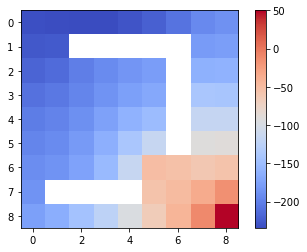

In [13]:
cmap = matplotlib.cm.coolwarm
im = plt.imshow(v_table,
                cmap=cmap,
                interpolation=None,#'nearest',
                origin='upper')
plt.colorbar(im)

### Greedified SARSA

In [14]:
def normalize(vec):
        vec = vec - vec.min()
        return vec / vec.sum()
    
def plot_q_table(env, q_table, title='', episode_num=100):
    
    fig = plt.figure(figsize=(14, 8))

    cmap = matplotlib.cm.coolwarm

    v_table_optimal = np.max(q_table, axis=2)
    im = plt.imshow(v_table_optimal, cmap=cmap, interpolation='nearest', origin='upper')

    for x in range(q_table.shape[0]):  # inverted because of imshow
        for y in range(q_table.shape[1]):  # inverted because of imshow
            state_q_values = q_table[x, y]
#             print(f"x={x}, y={y}, state_q_values={state_q_values}")
            state_q_values_norm = normalize(state_q_values)
#             print(f"x={x}, y={y}, state_q_values_norm={state_q_values_norm}")
            
            optimal_q = state_q_values_norm.max()
            for i, q in enumerate(state_q_values_norm):
                if q < optimal_q:#if q < 0.3:
                    continue
                if i == 0:  # UP is inverted because of imshow
                    plt.arrow(y, x, 0, -0.5 * q, fill=False, 
                              length_includes_head=True, head_width=0.1,
                              alpha=0.8, color='k')
                if i == 1:  # LEFT
                    plt.arrow(y, x, -0.5 * q, 0, fill=False, 
                              length_includes_head=True, head_width=0.1,
                              alpha=0.8, color='k')
                if i == 2:  # DOWN
                    plt.arrow(y, x, 0, 0.5 * q, fill=False, 
                              length_includes_head=True, head_width=0.1,
                              alpha=0.8, color='k')
                if i == 3:  # RIGHT
                    plt.arrow(y, x, 0.5 * q, 0, fill=False, 
                              length_includes_head=True, head_width=0.1,
                              alpha=0.8, color='k')


    plt.title((("" or title) + "\n") + "Optimal values and state actions, Episode: %d" % episode_num)
    plt.grid(b=False)
    plt.colorbar(im, orientation='vertical');

In [15]:
class GreedySARSA:
    def __init__(self, env: GridWorldEnv, 
                 eps=0.01, lr=0.1, gamma=0.99):
        self.env = env
        self.h, self.w = self.env.grid.shape
        self.q_table = np.zeros((self.h, self.w, 4))
        self.eps = eps
        self.lr = lr
        self.gamma = gamma

    def action(self, state):
        p = np.random.uniform(0, 1)
        if p > self.eps:
            state_q_values = self.q_table[state[0], state[1], :]
            max_q = max(state_q_values)
            candidate_ids = [i for i, q in enumerate(state_q_values) if q == max_q]
            return np.random.choice(candidate_ids)
        else:
            return random.randint(0, 3)
        
    def update(self, prev_state, prev_action, reward, state, action):
        target = reward + self.gamma*self.q_table[state[0], state[1], action]
        error = target - self.q_table[prev_state[0], prev_state[1], prev_action]
        self.q_table[prev_state[0], prev_state[1], prev_action] += self.lr*error
        
    def get_random_state(self):
        while True:
            h = random.randint(0, self.h-1)
            w = random.randint(0, self.w-1)
            if not self.env.is_stuck_with_obstacle(h, w):
                return (h, w)
            
        
    def evaluate_q(self, num_episodes):
        for _ in range(num_episodes):
            state = self.get_random_state()
            env.env_init(start_state=state)
            _, _, terminal = env.env_start()
            action = self.action(state)
            while not terminal:  # generate an episode
                reward, next_state, terminal = self.env.env_step(action)
                next_action = self.action(next_state)
                self.update(state, action, reward, next_state, next_action)
                state, action = next_state, next_action

In [16]:
sarsa = GreedySARSA(env, eps=0.05)
sarsa.q_table.shape

(9, 9, 4)

In [17]:
%%time

n_iters = 100000
experiment_name = "SARSA"

sarsa.evaluate_q(n_iters)

CPU times: user 23.3 s, sys: 745 ms, total: 24.1 s
Wall time: 23.7 s


<ipython-input-14-34cdec28c5d2>:3: RuntimeWarning: invalid value encountered in true_divide
  return vec / vec.sum()


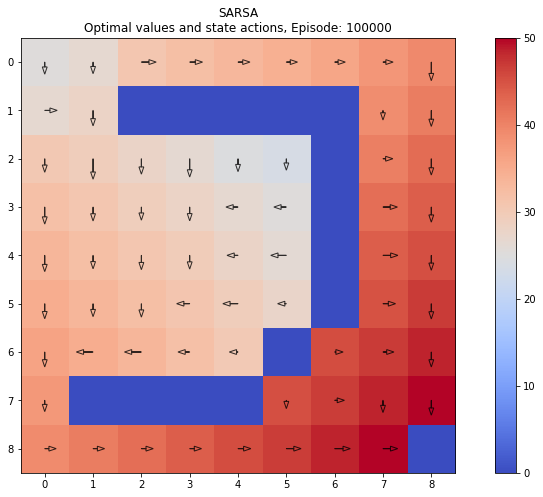

In [18]:
plot_q_table(env, sarsa.q_table, 
             title=experiment_name,
             episode_num=n_iters)

### Q-learning
Use Q-learning to search for an optimal policy. Compare to the solution obtained by SARSA.

In [19]:
class Qlearning(GreedySARSA):
    def update(self, prev_state, prev_action, reward, state):
        target = reward + self.gamma*self.q_table[state[0], state[1], :].max()
        error = target - self.q_table[prev_state[0], prev_state[1], prev_action]
        self.q_table[prev_state[0], prev_state[1], prev_action] += self.lr*error
        
    def evaluate_q(self, num_episodes):
        for _ in range(num_episodes):
            state = self.get_random_state()
            env.env_init(start_state=state)
            _, _, terminal = env.env_start()
            action = self.action(state)
            while not terminal:  # generate an episode
                reward, next_state, terminal = self.env.env_step(action)
                self.update(state, action, reward, next_state)
                
                next_action = self.action(next_state)
                state, action = next_state, next_action

In [20]:
q_learning = Qlearning(env, eps=0.05)
q_learning.q_table.shape

(9, 9, 4)

In [21]:
%%time

n_iters = 100000
experiment_name = "Q-learning"

q_learning.evaluate_q(n_iters)

CPU times: user 27 s, sys: 567 ms, total: 27.6 s
Wall time: 27.5 s


<ipython-input-14-34cdec28c5d2>:3: RuntimeWarning: invalid value encountered in true_divide
  return vec / vec.sum()


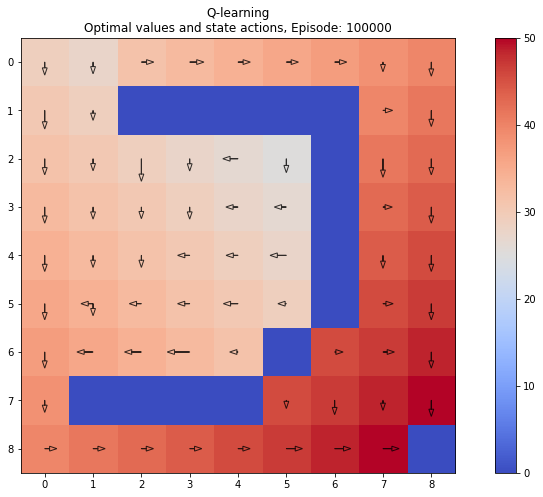

In [22]:
plot_q_table(env, q_learning.q_table, 
             title=experiment_name,
             episode_num=n_iters)